## Import event log

- Describe and visualize the general underlying process flow. Make sure you provide a reasonable level of abstraction. You may use BPMN / Petri Nets.

- How long do the different process instances take? Are there any notable patterns?
- Are there any bottlenecks? If yes, where? If yes, can you think of any reasons?
    -> Prozessdauer vizualisieren auf Petri Net(?)
 
- Are there any patterns that would suggest non-conformance?
    -> Conformance [check from PM4PY](https://pm4py.fit.fraunhofer.de/documentation#conformance)


- How many applications get rejected? Can you find any reasons?
--- 
- Can you find any unexpected behavior, e.g. missing permits?

- Are there notable differences between international and domestic declarations?
---

- What is missing to provide more detailed insights into the processes?

- Reflect on where supervised / unsupervised machine learning techniques could help to obtain further insights.
 
- Can you think of useful KPIs for the processes?

- Make specific recommendations for improving the processes
---
- TODO: Modularisation of code for analysis of domestic and international logdata

In [173]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import networkx as nx
%matplotlib inline
warnings.filterwarnings('ignore')

In [174]:
domestic_path = 'data/DomesticDeclarations.xes'
international_path = 'data/InternationalDeclarations.xes'

log= pm4py.read_xes(domestic_path);

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [230]:
log_int = pm4py.read_xes(international_path);

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

In [233]:
log_int.head(1)

,id,org:resource,concept:name,time:timestamp,org:role,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,case:Permit TaskNumber,...,case:concept:name,case:Permit OrganizationalEntity,case:travel permit number,case:Permit RequestedBudget,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount
0,rv_travel permit 76455_6,STAFF MEMBER,Start trip,2016-10-04 22:00:00+00:00,EMPLOYEE,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,declaration 76457,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561


## Statistical Analysis of Event Data

In [175]:
log.head(10)

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 08:49:50+00:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 10:27:48+00:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 08:34:44+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 16:31:22+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
4,st_step 86798_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:26:14+00:00,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
5,st_step 86799_0,STAFF MEMBER,Declaration APPROVED by PRE_APPROVER,2017-02-22 09:29:21+00:00,PRE_APPROVER,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
6,st_step 86797_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-02-23 07:14:45+00:00,SUPERVISOR,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
7,dd_declaration 86795_19,SYSTEM,Request Payment,2017-03-06 13:07:25+00:00,UNDEFINED,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
8,dd_declaration 86795_20,SYSTEM,Payment Handled,2017-03-13 16:30:59+00:00,UNDEFINED,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
9,st_step 86804_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:13:33+00:00,EMPLOYEE,declaration 86800,declaration 86800,budget 86566,declaration number 86801,320.646137


    - id: Unique ID for each step in the process.
    - org:resource: The resource (person, system) that performed the activity.
    - concept:name: Name of the activity
    - time:timestamp: Timestamp of the activity
    - org:role: Role of the resource in the process
    - case:id: Unique ID for each case (process instance)
    - case:concept:name: Another name for each case
    - case:BudgetNumber: Budget number for the case (does not change)
    - case:DeclarationNumber: Declaration number for the case
    - case:Amount: Requested Amount for the case
    - start_timestamp: Another timestamp of the activity


In [176]:
# show rows where case:id not equal case:concept:name
log[log['case:id'] != log['case:concept:name']]

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount


It looks like case_id and case_concept_name columns are the same.

In [177]:
# to improve readability we trim the word 'Declaration' out of concept:name column, if it exists
log['concept:name'] = log['concept:name'].str.replace('Declaration ', '')

In [178]:
# pick random case
case_ids = log['case:id'].unique()
random_case = log[log['case:id'] == np.random.choice(case_ids)]
random_case = random_case.sort_values(by='time:timestamp')
random_case

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
19150,st_step 109879_0,STAFF MEMBER,SUBMITTED by EMPLOYEE,2018-03-20 08:34:50+00:00,EMPLOYEE,declaration 109874,declaration 109874,budget 86566,declaration number 109875,47.058369
19151,st_step 109876_0,STAFF MEMBER,APPROVED by ADMINISTRATION,2018-04-07 10:46:30+00:00,ADMINISTRATION,declaration 109874,declaration 109874,budget 86566,declaration number 109875,47.058369
19152,st_step 109877_0,STAFF MEMBER,APPROVED by BUDGET OWNER,2018-04-11 13:34:59+00:00,BUDGET OWNER,declaration 109874,declaration 109874,budget 86566,declaration number 109875,47.058369
19153,st_step 109878_0,STAFF MEMBER,FINAL_APPROVED by SUPERVISOR,2018-04-12 06:37:37+00:00,SUPERVISOR,declaration 109874,declaration 109874,budget 86566,declaration number 109875,47.058369
19154,dd_declaration 109874_19,SYSTEM,Request Payment,2018-04-13 12:24:51+00:00,UNDEFINED,declaration 109874,declaration 109874,budget 86566,declaration number 109875,47.058369
19155,dd_declaration 109874_20,SYSTEM,Payment Handled,2018-04-16 15:31:09+00:00,UNDEFINED,declaration 109874,declaration 109874,budget 86566,declaration number 109875,47.058369


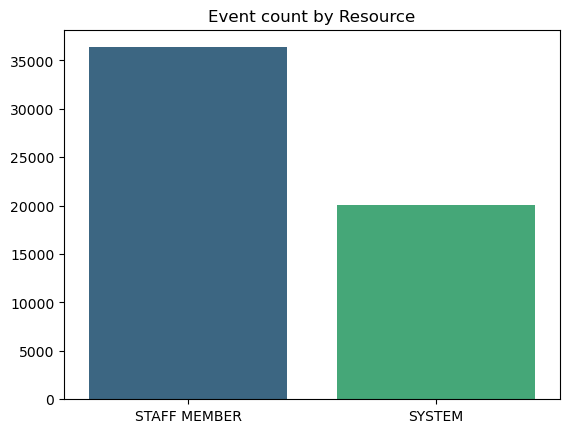

In [179]:
resources = log['org:resource'].unique()
sns.countplot(x='org:resource', data=log, palette='viridis').set(title='Event count by Resource', xlabel='', ylabel='');

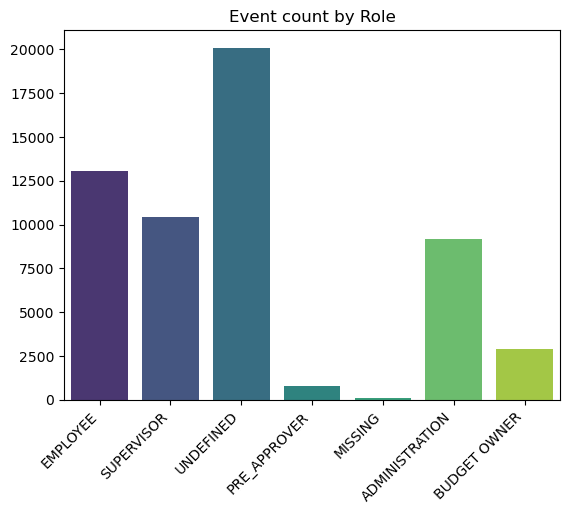

In [180]:
roles = log['org:role'].unique()
sns.countplot(x='org:role', data=log, palette='viridis').set(title='Event count by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

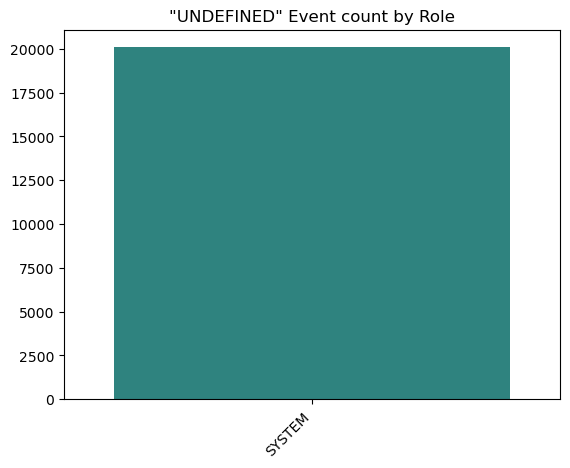

In [181]:
log_i = log[log['org:role'] == 'UNDEFINED']
sns.countplot(x='org:resource', data=log_i, palette='viridis').set(title='"UNDEFINED" Event count by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

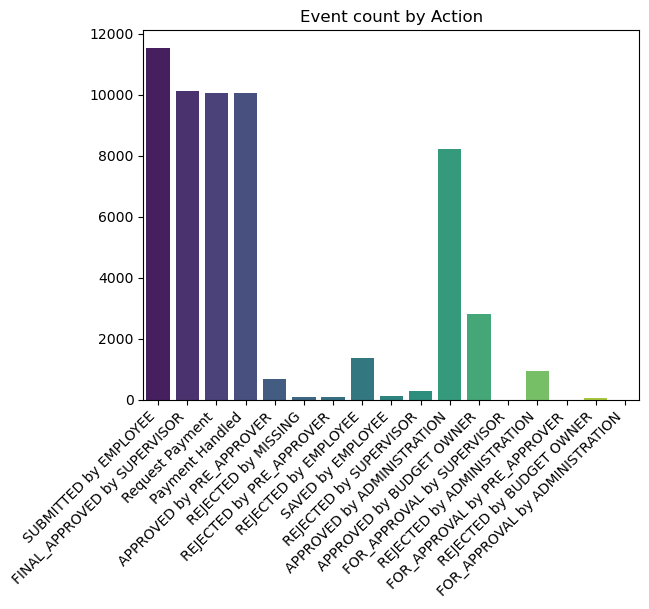

In [182]:
actions = log['concept:name'].unique()
sns.countplot(x='concept:name', data=log, palette='viridis').set(title='Event count by Action', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

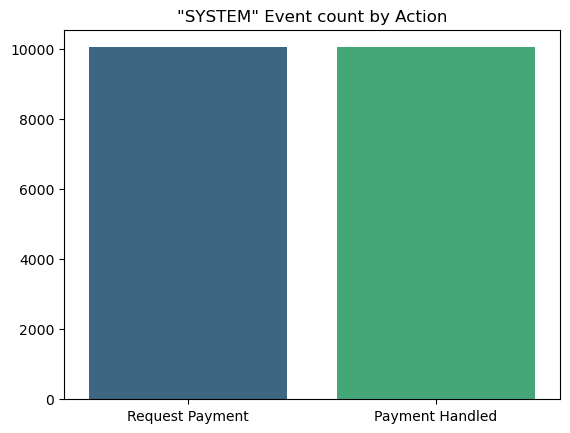

In [183]:
# System Events
log_s = log[log['org:resource'] == 'SYSTEM']
sns.countplot(x='concept:name', data=log_s, palette='viridis').set(title='"SYSTEM" Event count by Action', xlabel='', ylabel='');

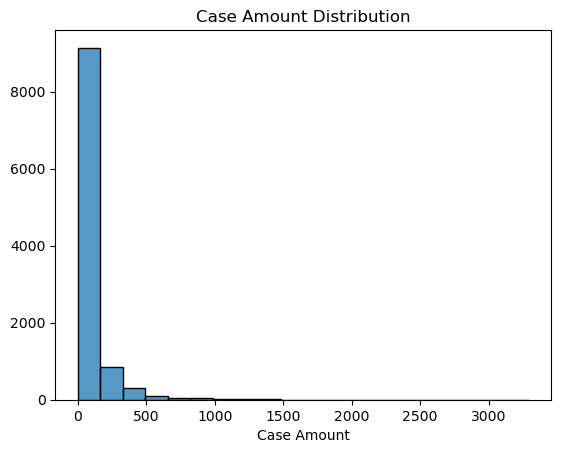

In [184]:
# case amount distribution for distinct case:id
distinct_case_amounts = log.groupby('case:id')['case:Amount'].max()
sns.histplot(distinct_case_amounts, kde=False, bins=20).set(title='Case Amount Distribution', xlabel='Case Amount', ylabel='');

## Process Discovery

Having mined the model we may vizualize it as a Process Tree or Petri Net.

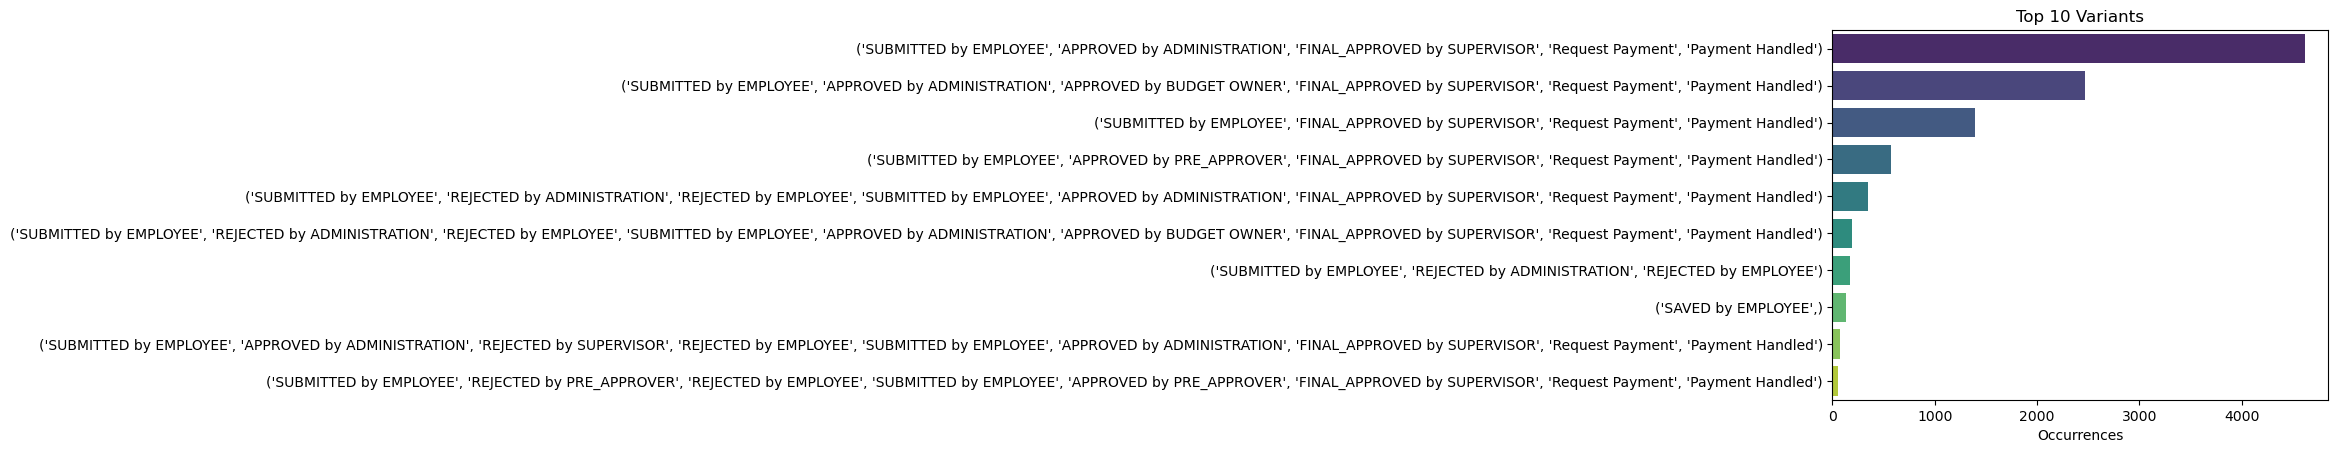

In [185]:
variants_dict = pm4py.get_variants(log)

variants_arr = []
idx = 1
for variant, n in variants_dict.items():
    variant_in_dict = {}
    variant_in_dict['variant_number'] = idx
    variant_in_dict['variant_count'] = n
    variant_in_dict['variant_trace'] = variant
    
    variants_arr.append(variant_in_dict)
    
    idx += 1


variants_df = pd.DataFrame(variants_arr)
variants_df = variants_df.sort_values(by='variant_count', ascending=False)

sns.barplot(x='variant_count', y='variant_trace', data=variants_df[:10], palette='viridis').set(title='Top 10 Variants', xlabel='Occurrences', ylabel='');

In [186]:
cases = log['case:id'].unique()
count_cases_top_10 = variants_df[:10]['variant_count'].sum()
print(f'Top 10 variants account for {count_cases_top_10:,} cases out of {len(cases):,}.')

Top 10 variants account for 10,033 cases out of 10,500.


## Check out BPMN Model

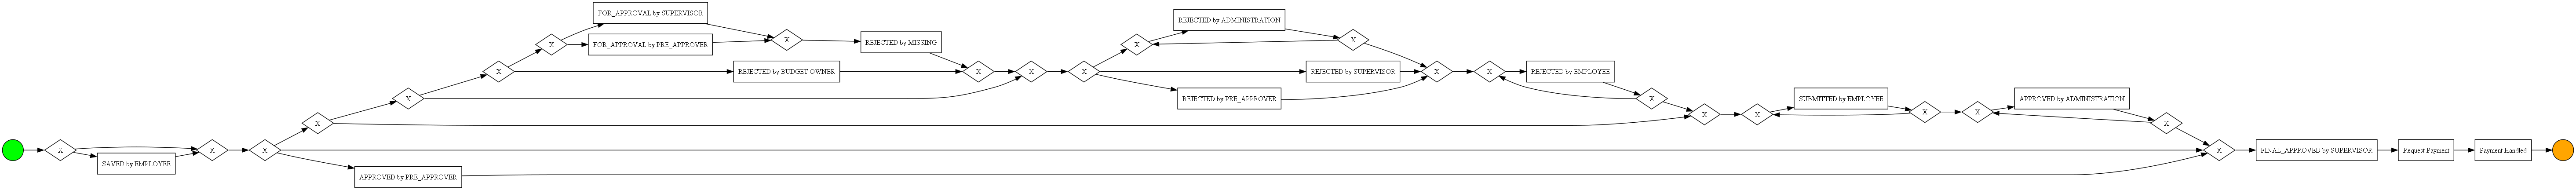

In [187]:
bpmn_model = pm4py.discover_bpmn_inductive(
    log=log,
    noise_threshold=0.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_bpmn(bpmn_model)

In BPMN model "x" stands for choice. We may observe that algorithm mined a model with a lot of choices and shortcuts. But on the end of the process it needs to be approved by supervisor. Last two stepps are done by system.

## Process Tree

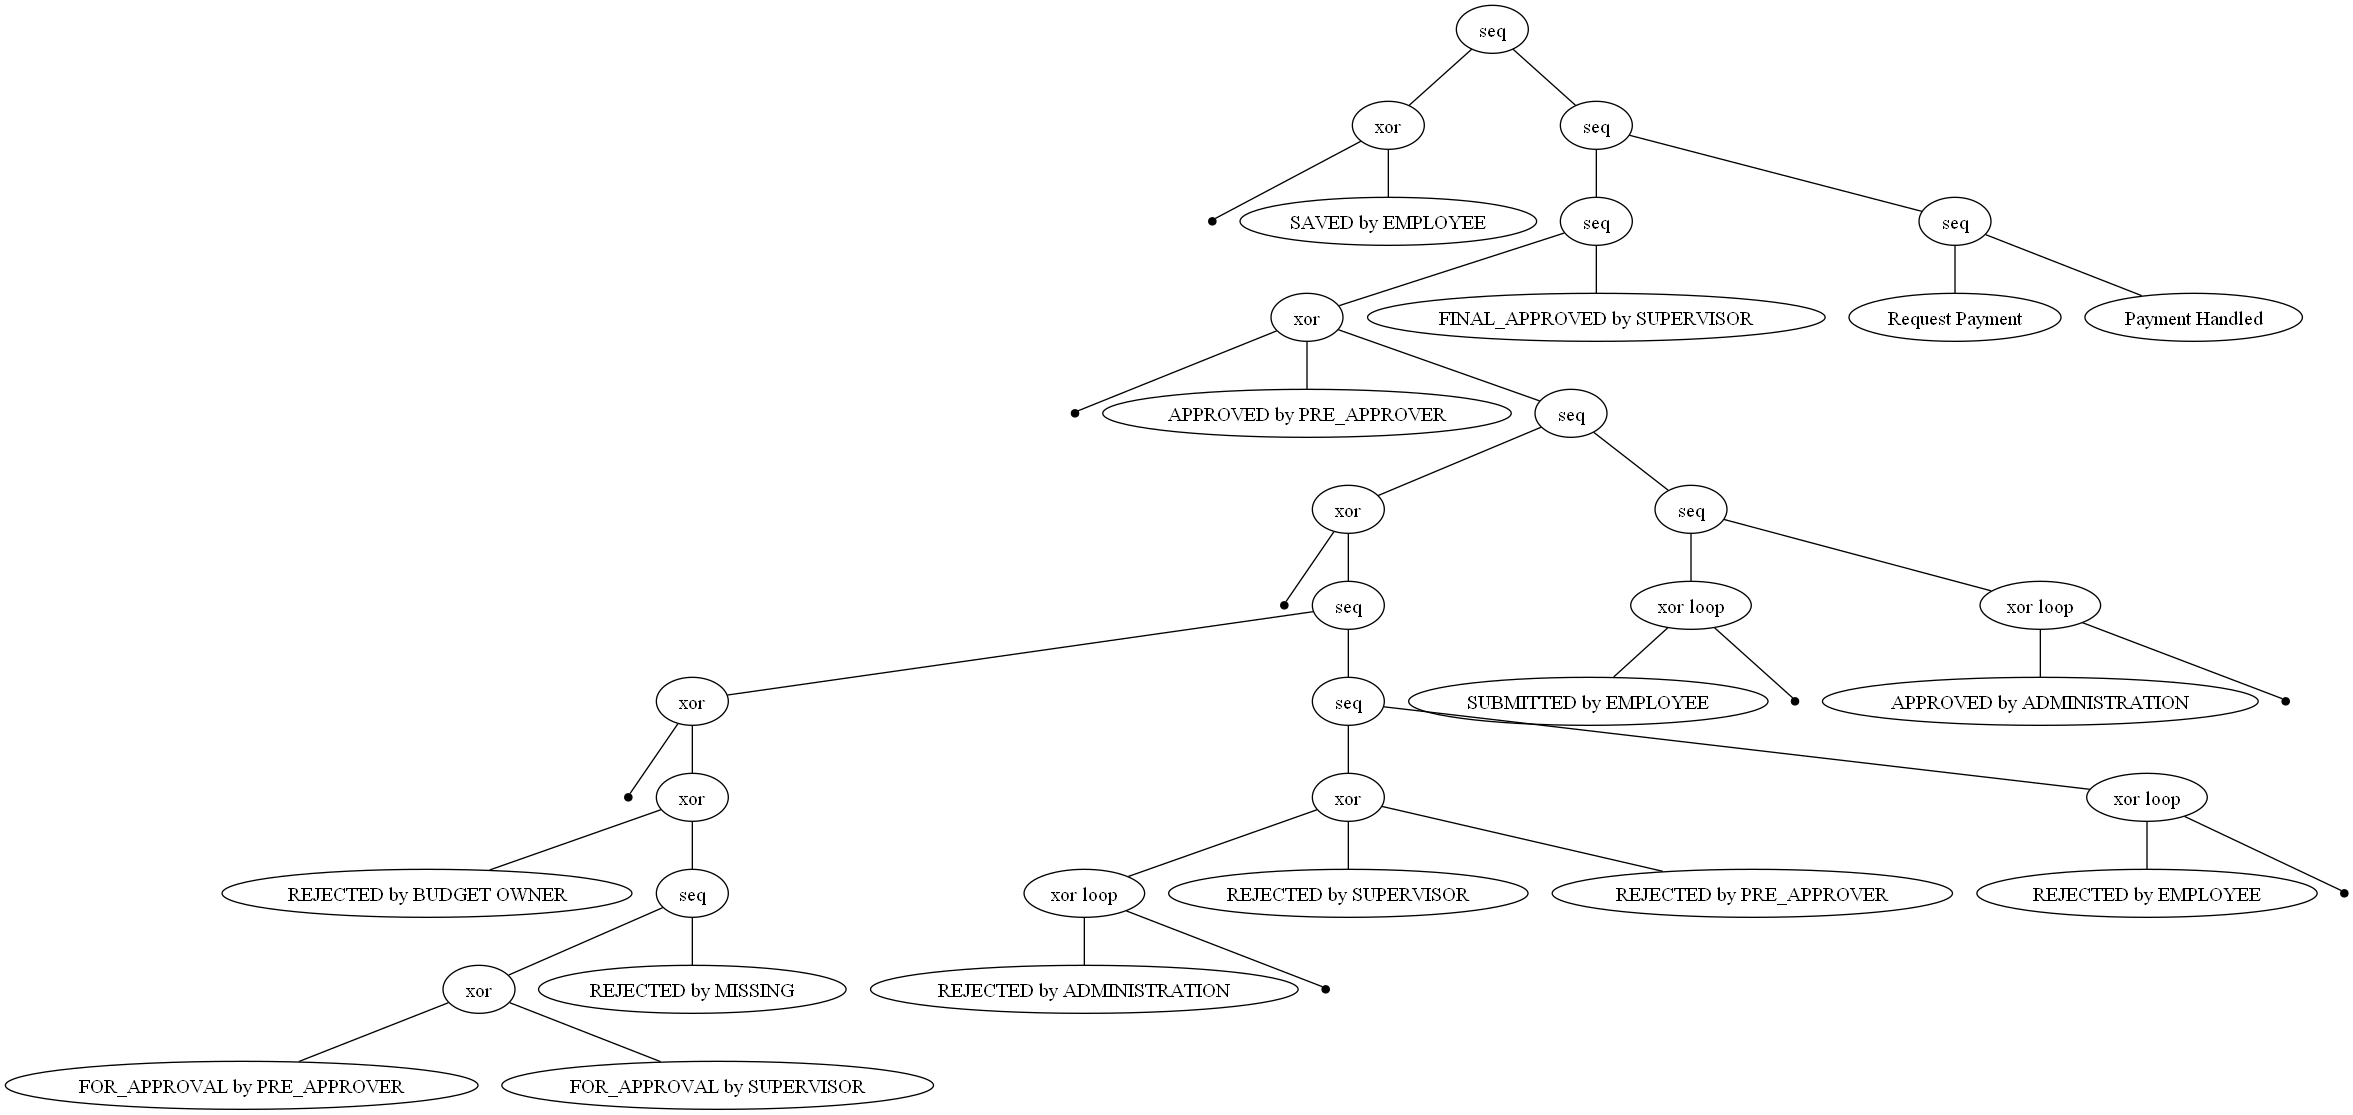

In [188]:
process_tree = pm4py.discover_process_tree_inductive(
    log=log,
    noise_threshold=.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_process_tree(process_tree)

## Petri Net

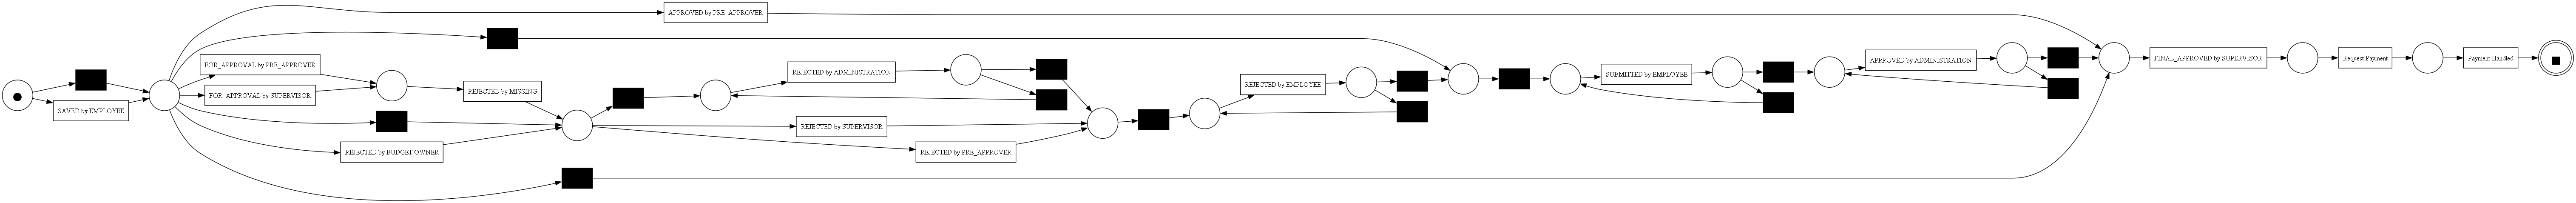

In [189]:
p_net, im, fm = pm4py.discover_petri_net_inductive(
    log=log,
    noise_threshold=.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_petri_net(p_net, im, fm)

## Directly-Follows Graph

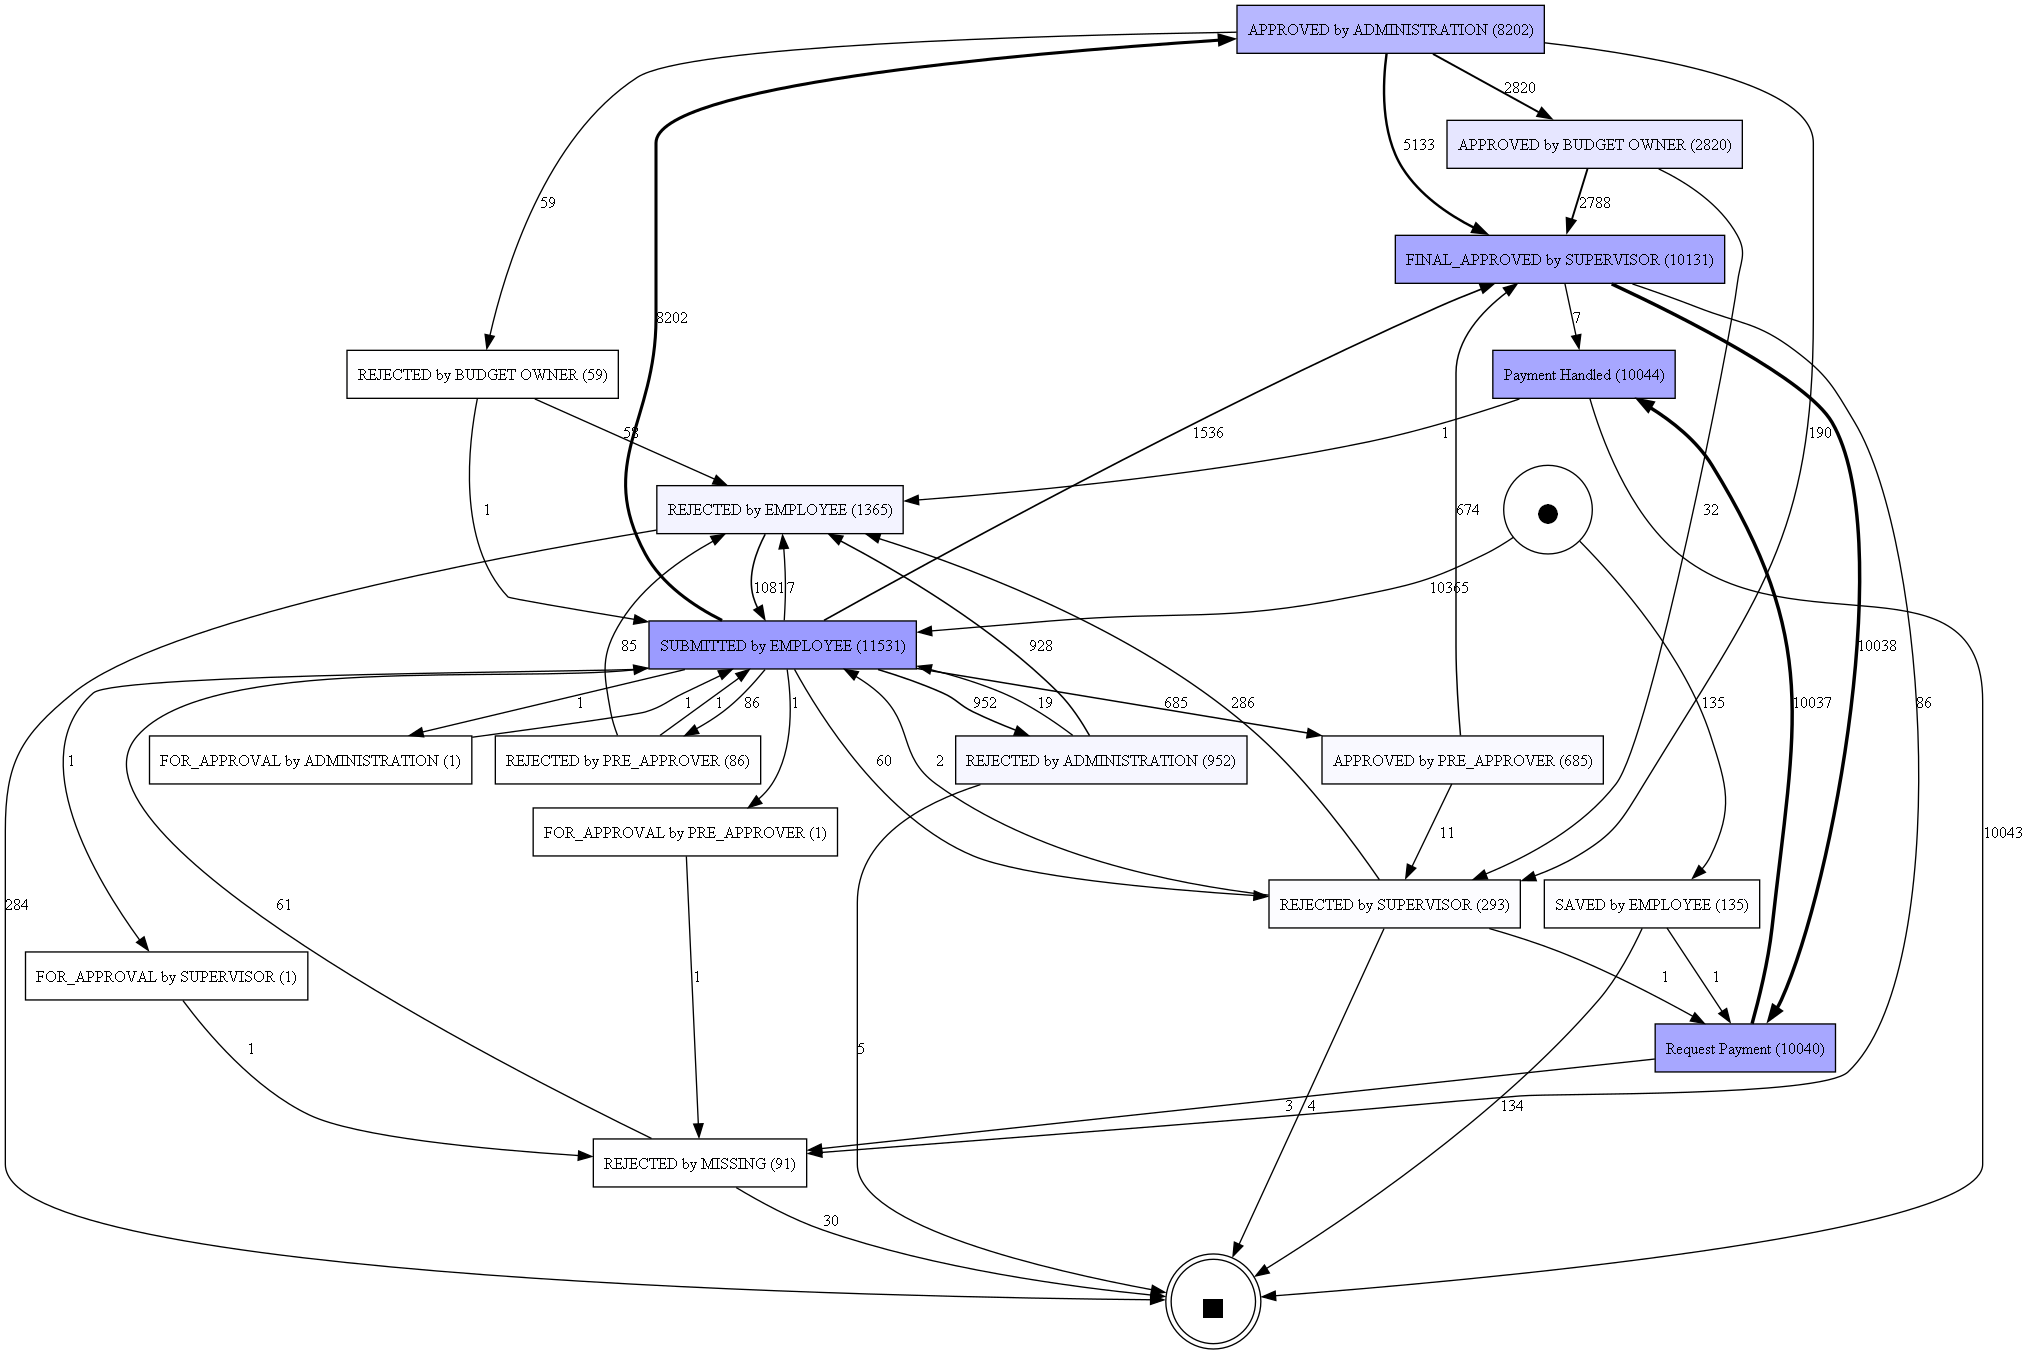

In [190]:
dfg, sa, ea = pm4py.discover_dfg(
    log=log,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_dfg(dfg, sa, ea)

Data Granularity mismatch?

TODO: Try to reshuffle events into new categories and create models again.

## Statistics

TODO

### Process Duration

- How long do the different process instances take? Are there any notable patterns?


Average duration of the whole process

This may take a while, because 'pm4py.get_case_duration' has to calculate the duration of all 10500 cases first


In [191]:
log_c = log['case:concept:name'].unique()
durations = []

for case in log_c:
    durations.append(pm4py.get_case_duration(
        log, 
        case, 
        activity_key='concept:name', 
        case_id_key='case:concept:name', 
        timestamp_key='time:timestamp'))

print(f"The average duration of the domestic process is: {np.array(durations).mean()/3600} hours. Min: {np.array(durations).min()/3600} hours. Max: {np.array(durations).max()/3600} hours. ")


The average duration of the domestic process is: 276.6173275132275 hours. Min: 0.0 hours. Max: 11261.671666666667 hours. 


In [192]:
case_arr_avg = pm4py.get_case_arrival_average( #Gets the average difference between the start times of two consecutive cases
    log, 
    activity_key='concept:name', 
    case_id_key='case:concept:name', 
    timestamp_key='time:timestamp')  

print(f"{case_arr_avg / 24} hours")

246.65215734831887 hours


--- 
Average duration of each activity

In [193]:
log = log.sort_values(['case:concept:name', 'time:timestamp'])

log['duration'] = log.groupby('case:concept:name')['time:timestamp'].diff()  # difference of one timestamp to next between two activities of one case

log[:10]

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount,start_timestamp,duration
12788,st_step 100004_0,STAFF MEMBER,SUBMITTED by EMPLOYEE,2018-01-30 08:20:07+00:00,EMPLOYEE,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,2018-01-30 08:20:07+00:00,NaT
12789,st_step 100003_0,STAFF MEMBER,APPROVED by ADMINISTRATION,2018-02-07 08:58:46+00:00,ADMINISTRATION,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,2018-02-07 08:58:46+00:00,8 days 00:38:39
12790,st_step 100002_0,STAFF MEMBER,FINAL_APPROVED by SUPERVISOR,2018-02-08 09:59:05+00:00,SUPERVISOR,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,2018-02-08 09:59:05+00:00,1 days 01:00:19
12791,dd_declaration 100000_19,SYSTEM,Request Payment,2018-02-09 11:42:49+00:00,UNDEFINED,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,2018-02-09 11:42:49+00:00,1 days 01:43:44
12792,dd_declaration 100000_20,SYSTEM,Payment Handled,2018-02-12 16:31:20+00:00,UNDEFINED,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,2018-02-12 16:31:20+00:00,3 days 04:48:31
12798,st_step 100009_0,STAFF MEMBER,SUBMITTED by EMPLOYEE,2018-01-30 08:38:54+00:00,EMPLOYEE,declaration 100005,declaration 100005,budget 86566,declaration number 100006,35.133685,2018-01-30 08:38:54+00:00,NaT
12799,st_step 100008_0,STAFF MEMBER,APPROVED by ADMINISTRATION,2018-01-30 08:38:57+00:00,ADMINISTRATION,declaration 100005,declaration 100005,budget 86566,declaration number 100006,35.133685,2018-01-30 08:38:57+00:00,0 days 00:00:03
12800,st_step 100007_0,STAFF MEMBER,FINAL_APPROVED by SUPERVISOR,2018-01-30 09:04:10+00:00,SUPERVISOR,declaration 100005,declaration 100005,budget 86566,declaration number 100006,35.133685,2018-01-30 09:04:10+00:00,0 days 00:25:13
12801,dd_declaration 100005_19,SYSTEM,Request Payment,2018-01-31 11:45:18+00:00,UNDEFINED,declaration 100005,declaration 100005,budget 86566,declaration number 100006,35.133685,2018-01-31 11:45:18+00:00,1 days 02:41:08
12802,dd_declaration 100005_20,SYSTEM,Payment Handled,2018-02-01 16:31:17+00:00,UNDEFINED,declaration 100005,declaration 100005,budget 86566,declaration number 100006,35.133685,2018-02-01 16:31:17+00:00,1 days 04:45:59


Activities of the start of each case have a duration value of NaT. Each will be replaced by 0

In [194]:
log['duration'].fillna(pd.Timedelta(seconds=0), inplace=True) 

In [195]:
average_durations = log.groupby('concept:name')['duration'].mean()
average_durations

concept:name
APPROVED by ADMINISTRATION        1 days 03:44:13.996342355
APPROVED by BUDGET OWNER          1 days 21:32:54.049645390
APPROVED by PRE_APPROVER          1 days 05:47:45.986861313
FINAL_APPROVED by SUPERVISOR      2 days 00:30:44.776823610
FOR_APPROVAL by ADMINISTRATION              0 days 00:09:49
FOR_APPROVAL by PRE_APPROVER                0 days 00:02:50
FOR_APPROVAL by SUPERVISOR                  0 days 00:00:03
Payment Handled                   3 days 15:05:42.273297491
REJECTED by ADMINISTRATION        5 days 15:53:54.662815126
REJECTED by BUDGET OWNER          1 days 06:47:30.288135593
REJECTED by EMPLOYEE              2 days 08:13:06.589743589
REJECTED by MISSING              11 days 02:28:52.329670329
REJECTED by PRE_APPROVER          1 days 22:43:13.360465116
REJECTED by SUPERVISOR            2 days 02:58:35.839590443
Request Payment                   3 days 03:57:07.309362549
SAVED by EMPLOYEE                           0 days 00:00:00
SUBMITTED by EMPLOYEE      

In [196]:
total_durations = log.groupby('concept:name')['duration'].sum()
total_durations

concept:name
APPROVED by ADMINISTRATION        9479 days 04:41:18
APPROVED by BUDGET OWNER          5351 days 22:20:20
APPROVED by PRE_APPROVER           850 days 10:20:01
FINAL_APPROVED by SUPERVISOR     20478 days 07:30:34
FOR_APPROVAL by ADMINISTRATION       0 days 00:09:49
FOR_APPROVAL by PRE_APPROVER         0 days 00:02:50
FOR_APPROVAL by SUPERVISOR           0 days 00:00:03
Payment Handled                  36449 days 06:56:33
REJECTED by ADMINISTRATION        5390 days 15:23:19
REJECTED by BUDGET OWNER            75 days 16:42:47
REJECTED by EMPLOYEE              3197 days 10:14:55
REJECTED by MISSING               1010 days 09:47:22
REJECTED by PRE_APPROVER           167 days 09:57:09
REJECTED by SUPERVISOR             622 days 08:09:01
Request Payment                  31773 days 06:23:06
SAVED by EMPLOYEE                    0 days 00:00:00
SUBMITTED by EMPLOYEE             6173 days 17:17:13
Name: duration, dtype: timedelta64[ns]

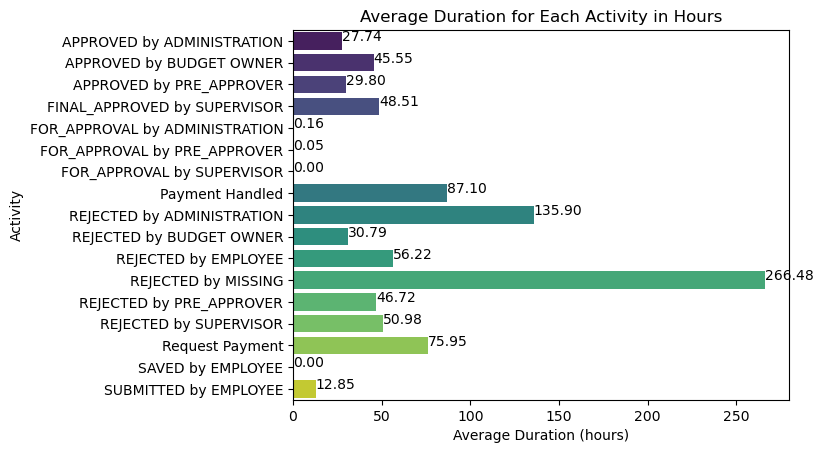

In [197]:

average_durations_hours = average_durations.dt.total_seconds() / 3600 # Conversion to hours

sns.barplot(x=average_durations_hours.values, y=average_durations_hours.index, palette="viridis")

plt.ylabel('Activity')
plt.xlabel('Average Duration (hours)')
plt.title('Average Duration for Each Activity in Hours')

for i, value in enumerate(average_durations_hours.values):  # Display values next to the bars
    plt.text(value, i, f"{value:.2f}")

plt.show()

The barchart above displays the avereage duration of each activity to another.  
TBD: Show Min /Median / Max Duration. Maybe replace this barchart with boxplot.

Text:
- Payment Handled: Last Activity of most cases 
- Saved by employee
- REJECTED by MISSING

In [198]:
log[log['concept:name'] == 'SAVED by EMPLOYEE']  # only 135 occurencies

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount,start_timestamp,duration
12150,st_step 100881_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-01-24 21:34:06+00:00,EMPLOYEE,declaration 100880,declaration 100880,budget 86566,UNKNOWN,0.0,2018-01-24 21:34:06+00:00,0 days
16749,st_step 101427_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-02-27 14:19:55+00:00,EMPLOYEE,declaration 101426,declaration 101426,budget 86566,UNKNOWN,0.0,2018-02-27 14:19:55+00:00,0 days
12755,st_step 101611_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-01-29 19:32:54+00:00,EMPLOYEE,declaration 101610,declaration 101610,budget 86566,UNKNOWN,0.0,2018-01-29 19:32:54+00:00,0 days
13621,st_step 101988_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-02-05 07:45:45+00:00,EMPLOYEE,declaration 101987,declaration 101987,budget 86566,UNKNOWN,0.0,2018-02-05 07:45:45+00:00,0 days
10505,st_step 102048_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-01-10 12:27:40+00:00,EMPLOYEE,declaration 102047,declaration 102047,budget 86566,UNKNOWN,0.0,2018-01-10 12:27:40+00:00,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...
14222,st_step 97402_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-02-07 12:18:13+00:00,EMPLOYEE,declaration 97401,declaration 97401,budget 86566,UNKNOWN,0.0,2018-02-07 12:18:13+00:00,0 days
20621,st_step 98056_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-03-29 15:02:06+00:00,EMPLOYEE,declaration 98055,declaration 98055,budget 86566,UNKNOWN,0.0,2018-03-29 15:02:06+00:00,0 days
10067,st_step 99094_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-01-06 09:33:56+00:00,EMPLOYEE,declaration 99093,declaration 99093,budget 86566,UNKNOWN,0.0,2018-01-06 09:33:56+00:00,0 days
10990,st_step 99494_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-01-16 10:32:21+00:00,EMPLOYEE,declaration 99493,declaration 99493,budget 86566,UNKNOWN,0.0,2018-01-16 10:32:21+00:00,0 days


Filtering now those rows with the same case:concept:name as those where concept:name == SAVED by Employee

In [199]:
saved_by_employee_rows = log[log['concept:name'] == 'SAVED by EMPLOYEE']

unique_case_concept_names = saved_by_employee_rows['case:concept:name'].unique()

filtered_log = log[log['case:concept:name'].isin(unique_case_concept_names)]
filtered_log  # 137 occurencies

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount,start_timestamp,duration
12150,st_step 100881_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-01-24 21:34:06+00:00,EMPLOYEE,declaration 100880,declaration 100880,budget 86566,UNKNOWN,0.0,2018-01-24 21:34:06+00:00,0 days
16749,st_step 101427_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-02-27 14:19:55+00:00,EMPLOYEE,declaration 101426,declaration 101426,budget 86566,UNKNOWN,0.0,2018-02-27 14:19:55+00:00,0 days
12755,st_step 101611_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-01-29 19:32:54+00:00,EMPLOYEE,declaration 101610,declaration 101610,budget 86566,UNKNOWN,0.0,2018-01-29 19:32:54+00:00,0 days
13621,st_step 101988_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-02-05 07:45:45+00:00,EMPLOYEE,declaration 101987,declaration 101987,budget 86566,UNKNOWN,0.0,2018-02-05 07:45:45+00:00,0 days
10505,st_step 102048_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-01-10 12:27:40+00:00,EMPLOYEE,declaration 102047,declaration 102047,budget 86566,UNKNOWN,0.0,2018-01-10 12:27:40+00:00,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...
14222,st_step 97402_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-02-07 12:18:13+00:00,EMPLOYEE,declaration 97401,declaration 97401,budget 86566,UNKNOWN,0.0,2018-02-07 12:18:13+00:00,0 days
20621,st_step 98056_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-03-29 15:02:06+00:00,EMPLOYEE,declaration 98055,declaration 98055,budget 86566,UNKNOWN,0.0,2018-03-29 15:02:06+00:00,0 days
10067,st_step 99094_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-01-06 09:33:56+00:00,EMPLOYEE,declaration 99093,declaration 99093,budget 86566,UNKNOWN,0.0,2018-01-06 09:33:56+00:00,0 days
10990,st_step 99494_0,STAFF MEMBER,SAVED by EMPLOYEE,2018-01-16 10:32:21+00:00,EMPLOYEE,declaration 99493,declaration 99493,budget 86566,UNKNOWN,0.0,2018-01-16 10:32:21+00:00,0 days


In [200]:
filtered_log[filtered_log['case:concept:name'] == 'declaration 95149']

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount,start_timestamp,duration
3356,st_step 95151_0,STAFF MEMBER,SAVED by EMPLOYEE,2017-05-12 13:23:58+00:00,EMPLOYEE,declaration 95149,declaration 95149,budget 86566,declaration number 95150,51.927888,2017-05-12 13:23:58+00:00,0 days 00:00:00
3357,dd_declaration 95149_19,SYSTEM,Request Payment,2017-05-29 14:11:59+00:00,UNDEFINED,declaration 95149,declaration 95149,budget 86566,declaration number 95150,51.927888,2017-05-29 14:11:59+00:00,17 days 00:48:01
3358,dd_declaration 95149_20,SYSTEM,Payment Handled,2017-06-01 15:30:51+00:00,UNDEFINED,declaration 95149,declaration 95149,budget 86566,declaration number 95150,51.927888,2017-06-01 15:30:51+00:00,3 days 01:18:52


Generally, the activity "SAVED by EMPLOYEE" seems to be no part of any workflow. The only case which has more than one activity containing the "SAVED by EMPLOYEE" activity, is declaration 95149

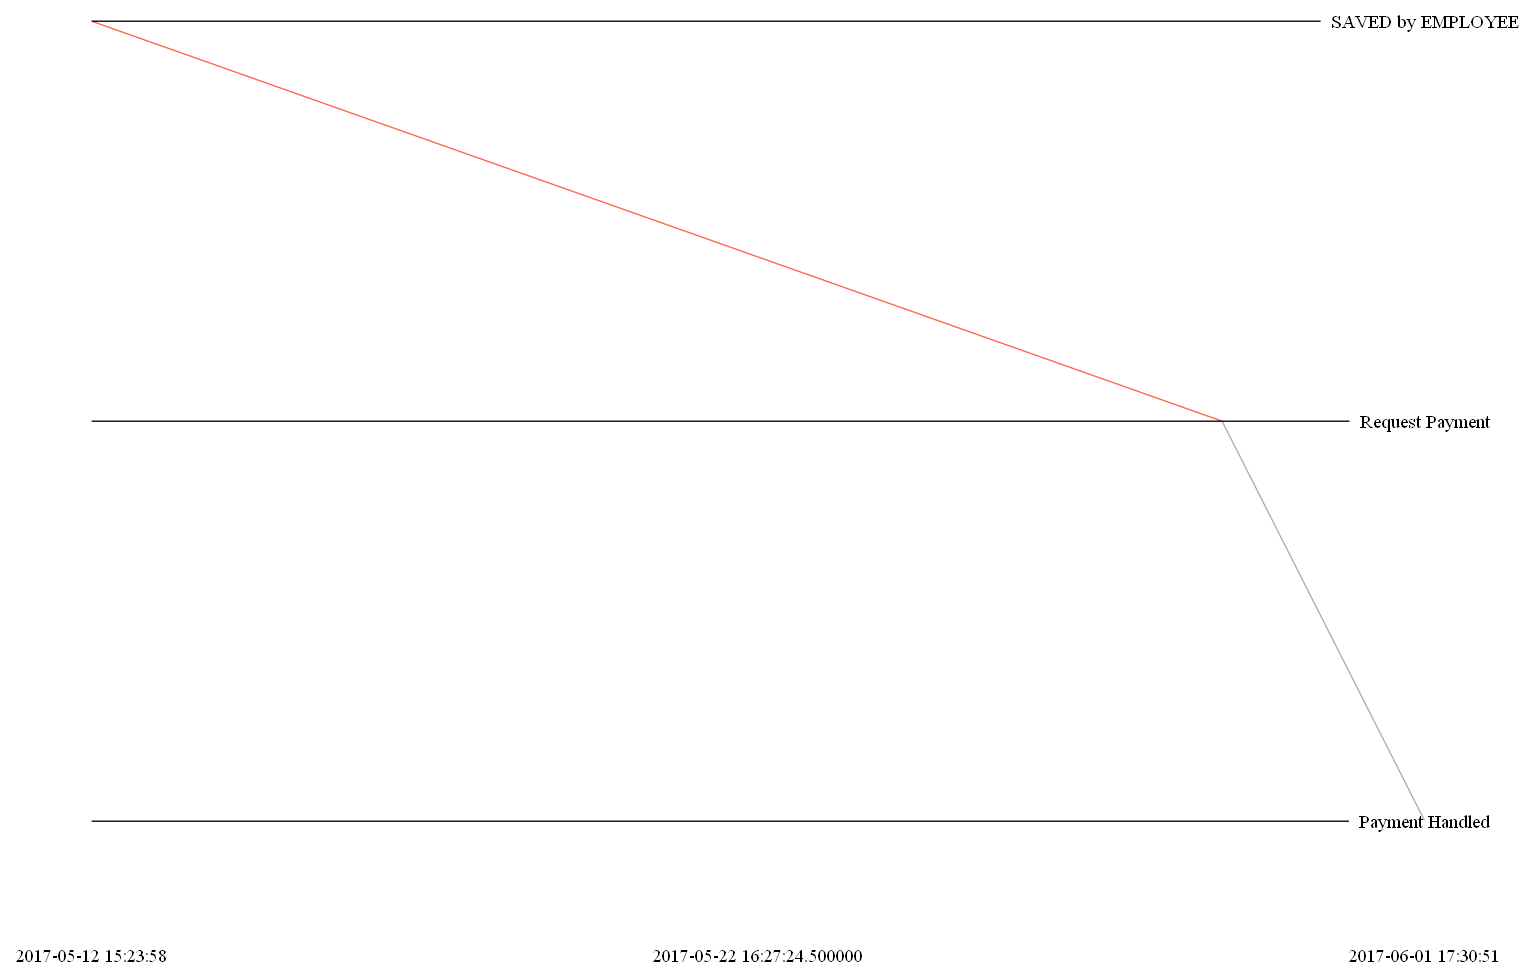

In [201]:
pm4py.view_performance_spectrum(
    log,
    ['SAVED by EMPLOYEE', 'Request Payment', 'Payment Handled'],
    format='png',
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp')

Total Duration of Each Activity in Days:

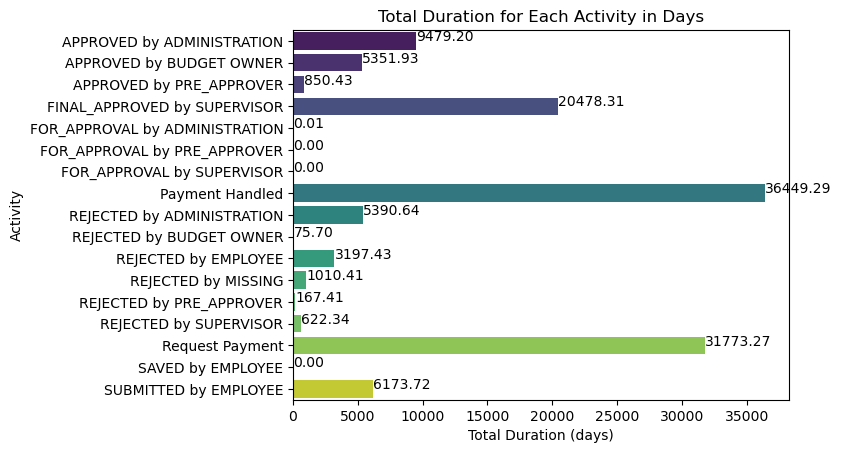

In [202]:
total_durations_days = total_durations.dt.total_seconds() / 3600 / 24 # Conversions to hours

sns.barplot(x=total_durations_days.values, y=total_durations_days.index, palette="viridis")


plt.ylabel('Activity')
plt.xlabel('Total Duration (days)')
plt.title('Total Duration for Each Activity in Days')

for i, value in enumerate(total_durations_days.values):  # Display values next to the bars
    plt.text(value, i, f"{value:.2f}")

plt.show()

The most time consuming activities are the those handled by the resource "SYSTEM", "Request Payment" and "Payment Handled". "FINAL_APPROVED by SUPERVISOR" seems to be another bottleneck.
As the starting activity of most cases the value for "SUBMITTED by EMPLOYEE" usually should be NaT or 0. But in this diagramm the total duration for "SUBMITTED by EMPLOYEE" represents the durations of those recycled declrations coming back from rejected declarations. 

--- 
- Are there any bottlenecks? If yes, where? If yes, can you think of any reasons?
    -> Prozessdauer vizualisieren auf Petri Net(?)
    -> [medium](https://medium.com/@c3_62722/process-mining-with-python-tutorial-a-healthcare-application-part-4-912286ee51b)

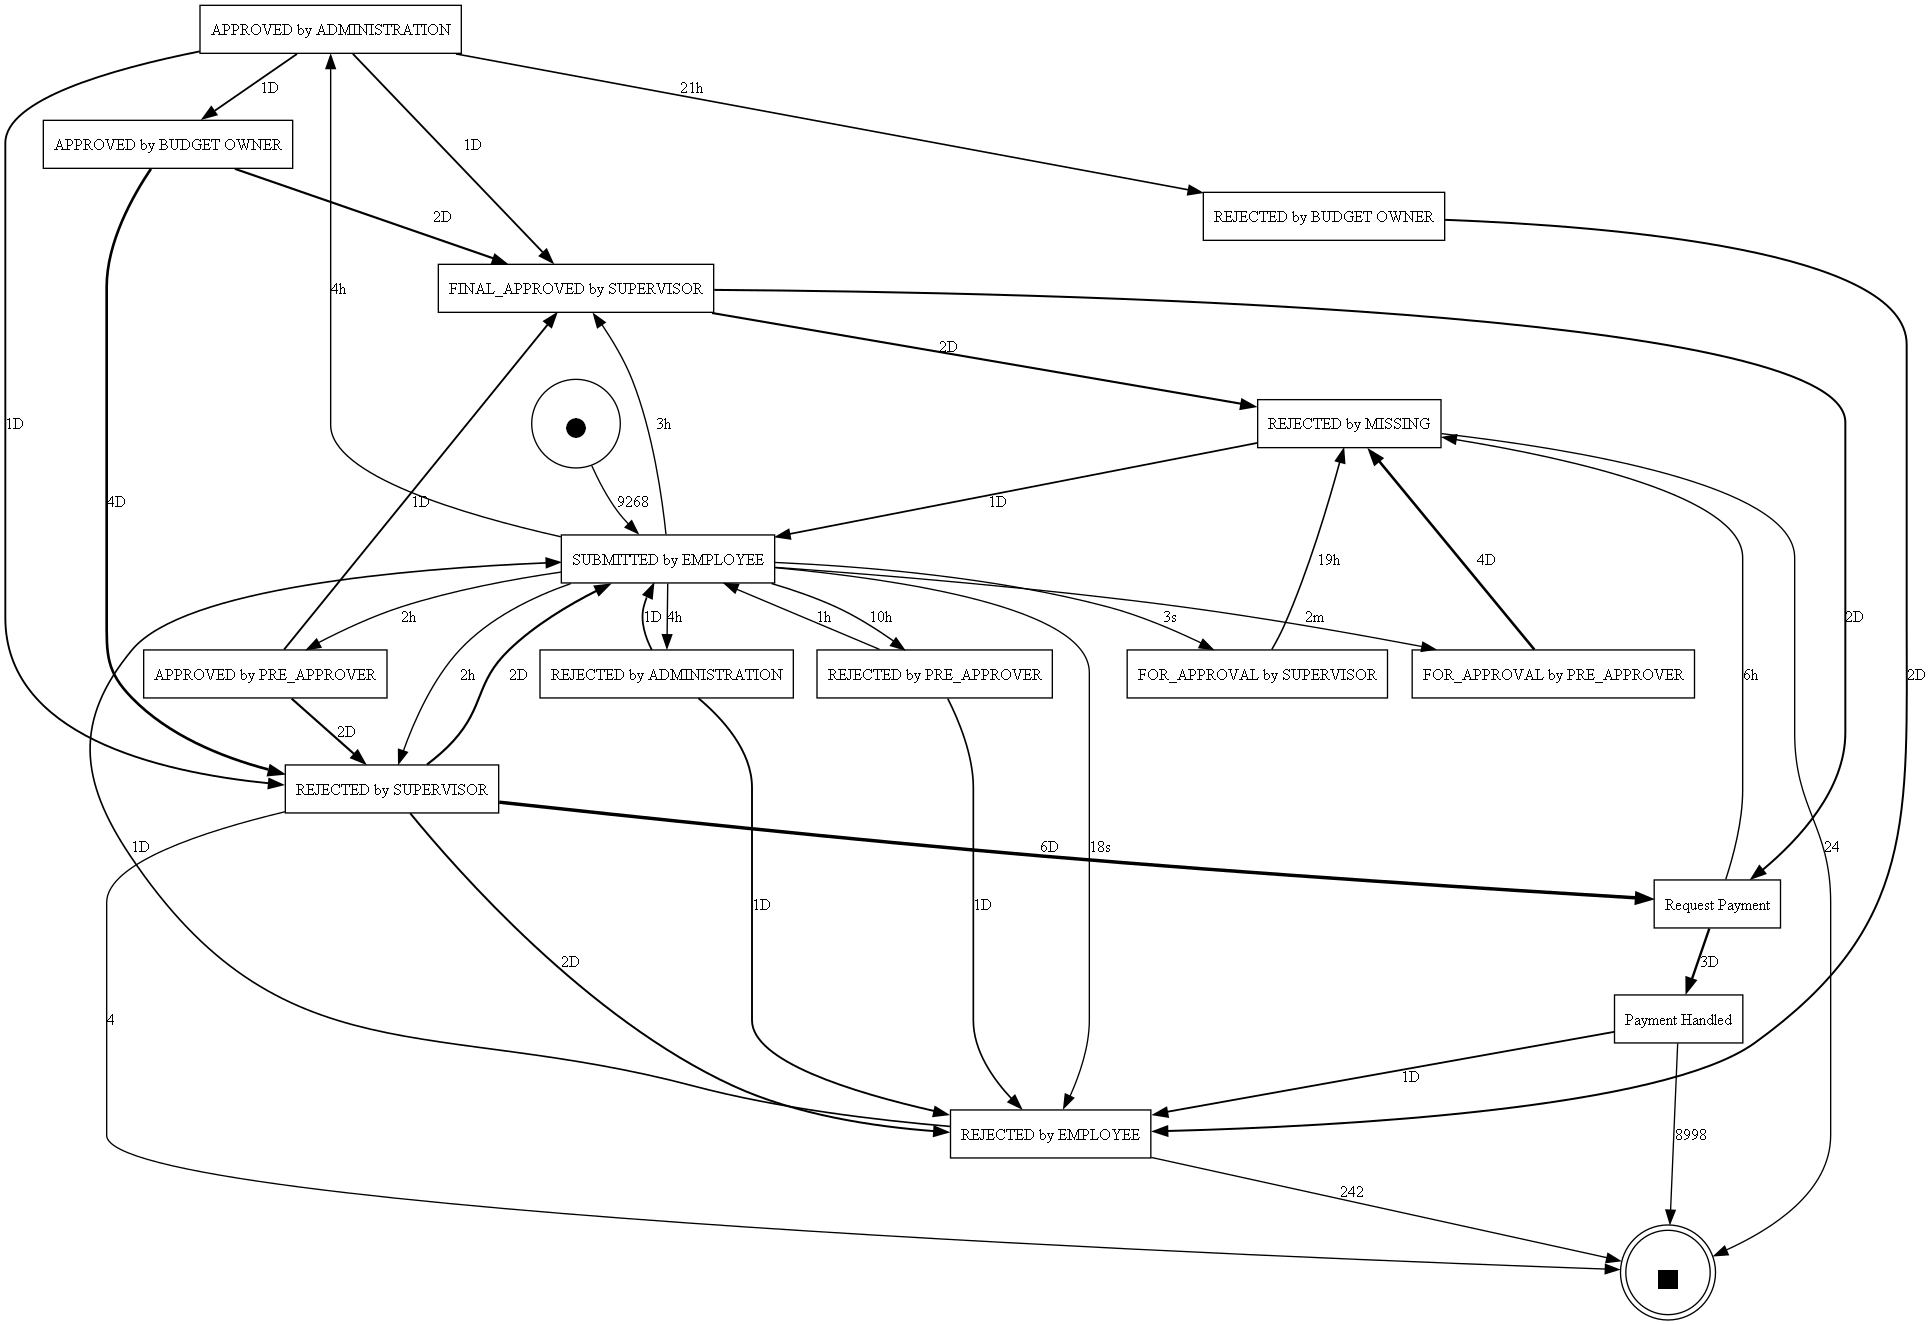

In [203]:
filtered_log = pm4py.filter_case_performance(  # log needs further filtering for adequate representation
    log, 
    3600.0, # min (1 min)
    1728000.0, #max (20d) in seconds
    timestamp_key='time:timestamp', 
    case_id_key='case:concept:name')  
     
#filtered_log = pm4py.filter_paths_performance(log, ('SUBMITTED by EMPLOYEE', 'Request Payment'), 0, 86400.0, activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(
    filtered_log, 
    case_id_key='case:concept:name', 
    activity_key='concept:name', 
    timestamp_key='time:timestamp')

pm4py.view_performance_dfg(
    performance_dfg, 
    start_activities, 
    end_activities, 
    format='png')

Obvious bottlenecks:
- Request Payment -> Payment Handled (System)

DISCO (Map -> Performance Total Duration): 
- "FINAL_APPROVED by SUPERVISOR" -> Request Payment (87yrs total)
- "Request Payment" -> "Payment Handled" (98,3 yrs total)
- "APPROVED by ADMINISTRATION" -> "FINAL_APPROVED by SUPERVISOR"
- "APPROVED by BUDGET OWNER" -> "FINAL_APPROVED by SUPERVISOR"

Additional remarks (from DISCO):
- only one case with "For_APPROVAL by SUPERVISOR" -> "REJECTED by MISSING"
- only one case with "SAVED by EMPLOYEE" -> "Request Payment"
- only one case with "For_APPROVAL by PRE_APPROVER" -> "REJECTED by MISSING"
- only one case with "For_APPROVAL by SUPERVISOR" -> "REJECTED by MISSING"
- only one case with "FOR_APPROVAL by ADMINISTRATION"
- 1081 declarations are getting recycled

In [204]:
start_activities = pm4py.get_start_activities(
    log, 
    activity_key='concept:name', 
    case_id_key='case:concept:name', 
    timestamp_key='time:timestamp')

end_activities = pm4py.get_end_activities(
    log, 
    activity_key='concept:name', 
    case_id_key='case:concept:name', 
    timestamp_key='time:timestamp')


In [205]:
start_activities

{'SUBMITTED by EMPLOYEE': 10365, 'SAVED by EMPLOYEE': 135}

In [206]:
end_activities

{'Payment Handled': 10043,
 'REJECTED by EMPLOYEE': 284,
 'SAVED by EMPLOYEE': 134,
 'REJECTED by MISSING': 30,
 'REJECTED by ADMINISTRATION': 5,
 'REJECTED by SUPERVISOR': 4}

In [207]:
act_pos = pm4py.get_activity_position_summary( # returns a dictionary which summarize the positions of the activities in the different cases of the event log
    log, 
    'SUBMITTED by EMPLOYEE', 
    activity_key='concept:name', 
    case_id_key='case:concept:name', 
    timestamp_key='time:timestamp')

act_pos

{0: 10365,
 3: 795,
 4: 194,
 6: 84,
 5: 30,
 7: 21,
 2: 12,
 8: 10,
 9: 9,
 12: 4,
 10: 3,
 13: 1,
 16: 1,
 19: 1,
 11: 1}

In [208]:
rework = pm4py.get_rework_cases_per_activity(log, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
rework  # Find out for which activities of the log the rework (more than one occurrence in the trace for the activity) occurs. -> almost 10% of the cases go back to "SUBMITTED by EMPLOYEE"

{'APPROVED by ADMINISTRATION': 210,
 'APPROVED by BUDGET OWNER': 13,
 'APPROVED by PRE_APPROVER': 18,
 'FINAL_APPROVED by SUPERVISOR': 58,
 'REJECTED by ADMINISTRATION': 93,
 'REJECTED by BUDGET OWNER': 1,
 'REJECTED by EMPLOYEE': 139,
 'REJECTED by MISSING': 3,
 'REJECTED by PRE_APPROVER': 5,
 'REJECTED by SUPERVISOR': 12,
 'SUBMITTED by EMPLOYEE': 1019}

--- 
- Handover Network

In [209]:

metric = pm4py.discover_handover_of_work_network(
    log, 
    resource_key='org:role', 
    timestamp_key='time:timestamp', 
    case_id_key='case:concept:name')  
pm4py.vis.view_sna(metric)  # Creates the .html file containing the network of the handover of work. See created .html file and open with a browser of your choice

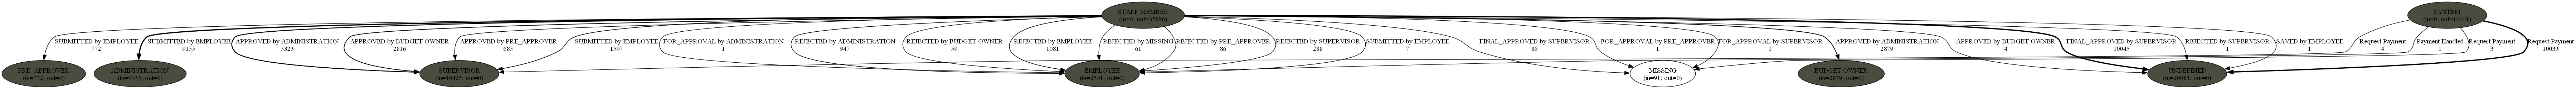

In [210]:

net_ana = pm4py.discover_network_analysis(
    log, 
    out_column='case:concept:name', 
    in_column='case:concept:name', 
    node_column_source='org:resource', 
    node_column_target='org:role', 
    edge_column='concept:name')

pm4py.view_network_analysis(net_ana, format='png')  # Less clear network in contrast to the created .html file

---
- nice to know:


In [211]:
# model fitness, needs an "ideal" process map as benchmark
net, im, fm = pm4py.discover_petri_net_inductive(log, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
fitness_alignments = pm4py.fitness_alignments(log, net, im, fm, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

In [212]:
fitness_alignments

{'percFitTraces': 100.0,
 'averageFitness': 1.0,
 'percentage_of_fitting_traces': 100.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 0.999534671885271}

In [213]:
# model fitness with tbr algorithm
net, im, fm = pm4py.discover_petri_net_inductive(log, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
fitness_tbr = pm4py.fitness_token_based_replay(log, net, im, fm, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

In [214]:
fitness_tbr

{'perc_fit_traces': 100.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 1.0,
 'percentage_of_fitting_traces': 100.0}

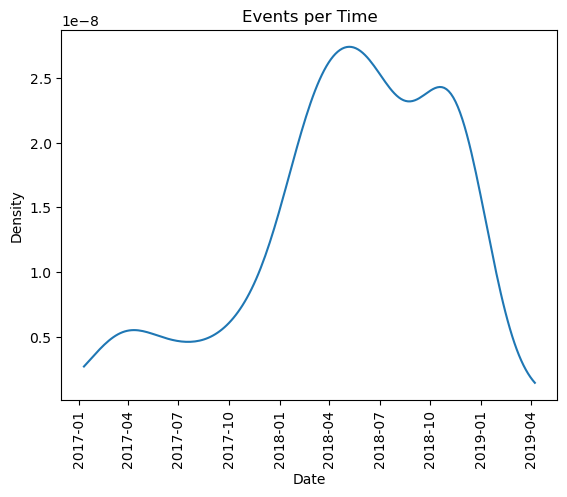

In [215]:
pm4py.view_events_per_time_graph(log, format='png', activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

---
- Are there any patterns that would suggest non-conformance?
    -> Conformance [check from PM4PY](https://pm4py.fit.fraunhofer.de/documentation#conformance)
    -> Needs Process Model / petri net (?) as baseline


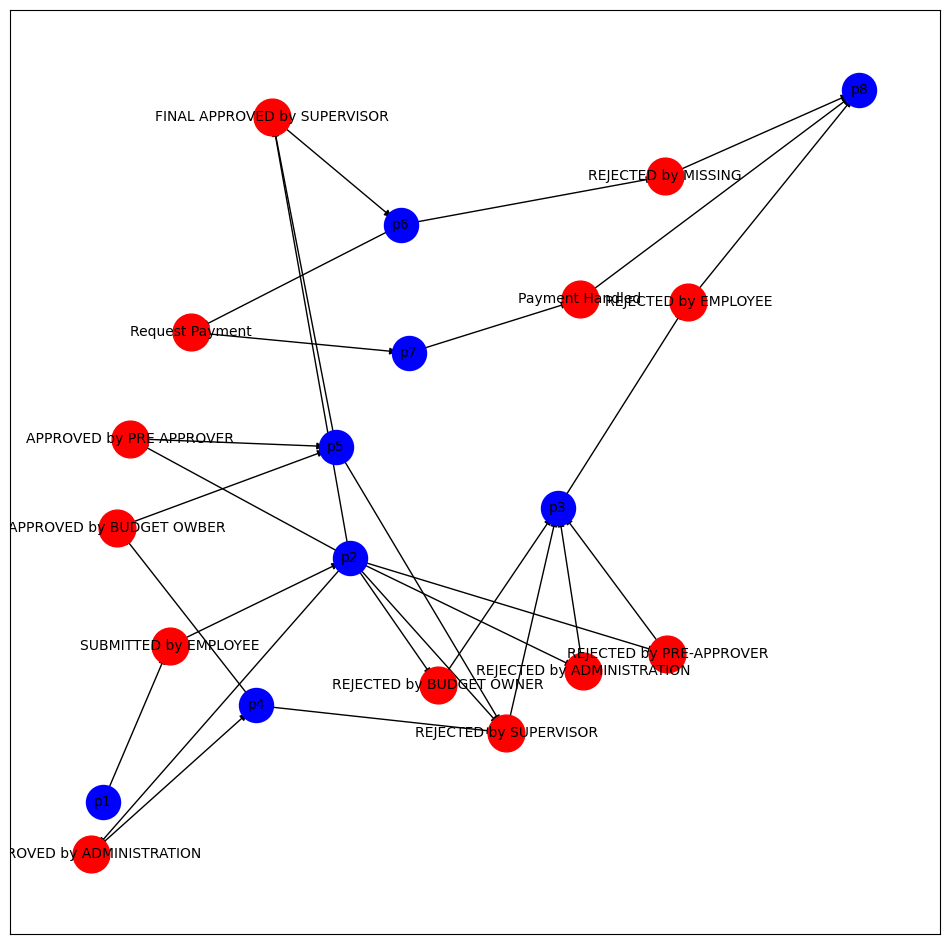

In [227]:



G = nx.DiGraph()

# nodes
places = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
transitions = ['SUBMITTED by EMPLOYEE', 'REJECTED by PRE-APPROVER', 'REJECTED by ADMINISTRATION', 'REJECTED by BUDGET OWNER', 'APPROVED by ADMINISTRATION', 'REJECTED by SUPERVISOR', 'APPROVED by PRE APPROVER', 'FINAL APPROVED by SUPERVISOR', 'APPROVED by BUDGET OWBER', 'REJECTED by EMPLOYEE', 'Request Payment', 'Payment Handled', 'REJECTED by MISSING']

G.add_nodes_from(places)
G.add_nodes_from(transitions)

edges = [('p1','SUBMITTED by EMPLOYEE'), ('SUBMITTED by EMPLOYEE','p2'), ('p2','REJECTED by PRE-APPROVER'), ('p2','REJECTED by ADMINISTRATION'), ('p2','REJECTED by BUDGET OWNER'), ('p2','APPROVED by ADMINISTRATION'), ('p2','REJECTED by SUPERVISOR'), ('p2','APPROVED by PRE APPROVER'), ('p2','FINAL APPROVED by SUPERVISOR'),
         ('REJECTED by PRE-APPROVER','p3'), ('REJECTED by ADMINISTRATION','p3'), ('REJECTED by BUDGET OWNER','p3'), ('REJECTED by SUPERVISOR','p3'), ('APPROVED by ADMINISTRATION','p4'), ('APPROVED by PRE APPROVER','p5'), ('FINAL APPROVED by SUPERVISOR','p6'), ('p4','REJECTED by SUPERVISOR'),('p4','APPROVED by BUDGET OWBER'), ('APPROVED by BUDGET OWBER','p5'), 
         ('p5','REJECTED by SUPERVISOR'), ('p5','FINAL APPROVED by SUPERVISOR'), ('p3','REJECTED by EMPLOYEE'), ('REJECTED by EMPLOYEE','p8'), ('p6','Request Payment'), ('p6','REJECTED by MISSING'), ('REJECTED by MISSING','p8'), ('Request Payment','p7'), ('p7','Payment Handled'), ('Payment Handled','p8')]

G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=1337)  # Positioning of nodes
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, nodelist=places, node_color='blue', node_size=600)
nx.draw_networkx_nodes(G, pos, nodelist=transitions, node_color='red', node_size=700)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.show()




---
- How many applications get rejected? Can you find any reasons?
-> amount?

In [217]:
log_r = log[log["concept:name"].str.contains('REJECTED')]
log_r

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount,start_timestamp,duration
23804,st_step 100129_0,STAFF MEMBER,REJECTED by ADMINISTRATION,2018-04-22 08:50:50+00:00,ADMINISTRATION,declaration 100122,declaration 100122,budget 86566,declaration number 100123,78.943767,2018-04-22 08:50:50+00:00,0 days 00:04:44
23805,st_step 100130_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-04-23 08:08:51+00:00,EMPLOYEE,declaration 100122,declaration 100122,budget 86566,declaration number 100123,78.943767,2018-04-23 08:08:51+00:00,0 days 23:18:01
1011,st_step 100203_0,STAFF MEMBER,REJECTED by MISSING,2018-01-08 12:54:03+00:00,MISSING,declaration 100197,declaration 100197,budget 86566,declaration number 100198,9.759093,2018-01-08 12:54:03+00:00,293 days 08:39:01
14984,st_step 100257_0,STAFF MEMBER,REJECTED by ADMINISTRATION,2018-02-12 15:05:40+00:00,ADMINISTRATION,declaration 100245,declaration 100245,budget 86566,declaration number 100246,280.265410,2018-02-12 15:05:40+00:00,0 days 00:10:31
14985,st_step 100255_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-02-13 08:58:29+00:00,EMPLOYEE,declaration 100245,declaration 100245,budget 86566,declaration number 100246,280.265410,2018-02-13 08:58:29+00:00,0 days 17:52:49
...,...,...,...,...,...,...,...,...,...,...,...,...
23708,st_step 99902_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-04-23 11:43:42+00:00,EMPLOYEE,declaration 99892,declaration 99892,budget 86566,declaration number 99893,45.777851,2018-04-23 11:43:42+00:00,3 days 00:02:00
23710,st_step 99898_0,STAFF MEMBER,REJECTED by ADMINISTRATION,2018-05-08 12:37:41+00:00,ADMINISTRATION,declaration 99892,declaration 99892,budget 86566,declaration number 99893,45.777851,2018-05-08 12:37:41+00:00,3 days 23:18:00
23711,st_step 99899_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-05-15 08:12:53+00:00,EMPLOYEE,declaration 99892,declaration 99892,budget 86566,declaration number 99893,45.777851,2018-05-15 08:12:53+00:00,6 days 19:35:12
11914,st_step 99916_0,STAFF MEMBER,REJECTED by ADMINISTRATION,2018-01-23 15:04:38+00:00,ADMINISTRATION,declaration 99909,declaration 99909,budget 86566,declaration number 99910,239.790518,2018-01-23 15:04:38+00:00,0 days 00:00:28


In [218]:
log_re = log[log['concept:name'].str.contains('REJECTED by EMPLOYEE')] 
log_re

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount,start_timestamp,duration
23805,st_step 100130_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-04-23 08:08:51+00:00,EMPLOYEE,declaration 100122,declaration 100122,budget 86566,declaration number 100123,78.943767,2018-04-23 08:08:51+00:00,0 days 23:18:01
14985,st_step 100255_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-02-13 08:58:29+00:00,EMPLOYEE,declaration 100245,declaration 100245,budget 86566,declaration number 100246,280.265410,2018-02-13 08:58:29+00:00,0 days 17:52:49
14989,st_step 100252_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-02-23 10:39:44+00:00,EMPLOYEE,declaration 100245,declaration 100245,budget 86566,declaration number 100246,280.265410,2018-02-23 10:39:44+00:00,1 days 02:52:18
9941,st_step 100371_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-01-30 14:52:08+00:00,EMPLOYEE,declaration 100365,declaration 100365,budget 86566,declaration number 100366,463.266777,2018-01-30 14:52:08+00:00,5 days 02:13:36
10405,st_step 100386_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-01-09 12:14:53+00:00,EMPLOYEE,declaration 100380,declaration 100380,budget 86566,declaration number 100381,44.422160,2018-01-09 12:14:53+00:00,0 days 00:21:34
...,...,...,...,...,...,...,...,...,...,...,...,...
23697,st_step 99884_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-04-23 14:07:01+00:00,EMPLOYEE,declaration 99880,declaration 99880,budget 86566,UNKNOWN,0.000000,2018-04-23 14:07:01+00:00,3 days 02:48:35
23700,st_step 99883_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-07-12 09:50:35+00:00,EMPLOYEE,declaration 99880,declaration 99880,budget 86566,UNKNOWN,0.000000,2018-07-12 09:50:35+00:00,2 days 01:35:24
23708,st_step 99902_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-04-23 11:43:42+00:00,EMPLOYEE,declaration 99892,declaration 99892,budget 86566,declaration number 99893,45.777851,2018-04-23 11:43:42+00:00,3 days 00:02:00
23711,st_step 99899_0,STAFF MEMBER,REJECTED by EMPLOYEE,2018-05-15 08:12:53+00:00,EMPLOYEE,declaration 99892,declaration 99892,budget 86566,declaration number 99893,45.777851,2018-05-15 08:12:53+00:00,6 days 19:35:12


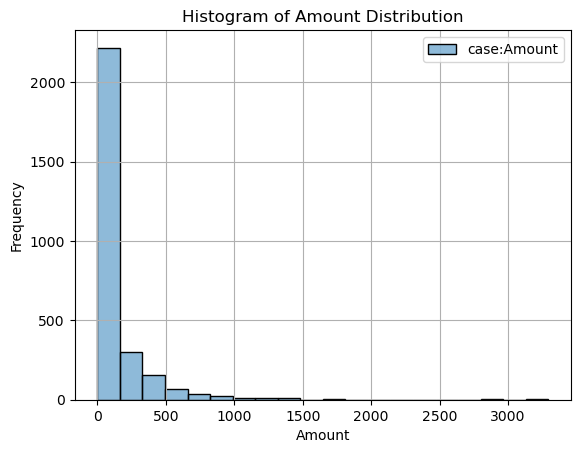

In [219]:

sns.histplot(log_r, kde=False, bins=20).set(title='Histogram of Amount Distribution', xlabel='Amount', ylabel='Frequency');
plt.grid(True)

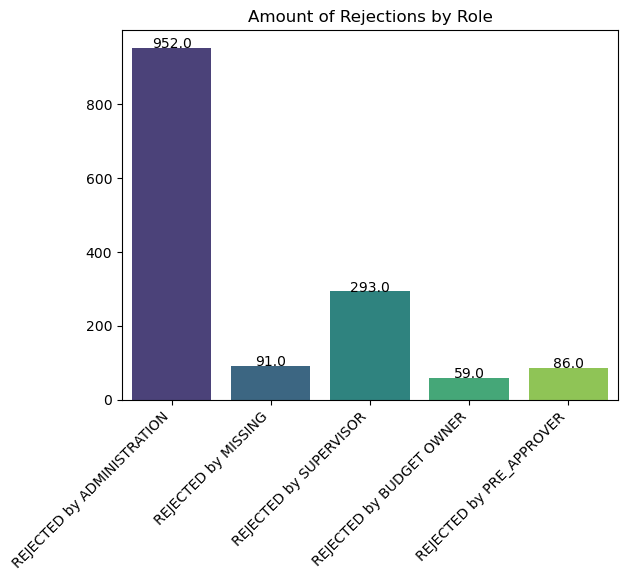

In [234]:
log_r = log_r[log_r['org:role'] != 'EMPLOYEE']   # Filtering out the EMPLOYEE role because most rejected declartions by a certain role are getting followed up by the activity "REJECTED by EMPLOYEE"
ax = sns.countplot(x='concept:name', data=log_r, palette='viridis')
ax.set(title='Amount of Rejections by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right')

# Werte an den Balken anzeigen
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline')  # centering text


In [221]:
log_a = log[log['concept:name'].str.contains('FINAL_APPROVED by SUPERVISOR|APPROVED by PRE_APPROVER|APPROVED by ADMINISTRATION|APPROVED by BUDGET OWNER', regex=True)]  # Filtering only mentioned roles into log_a

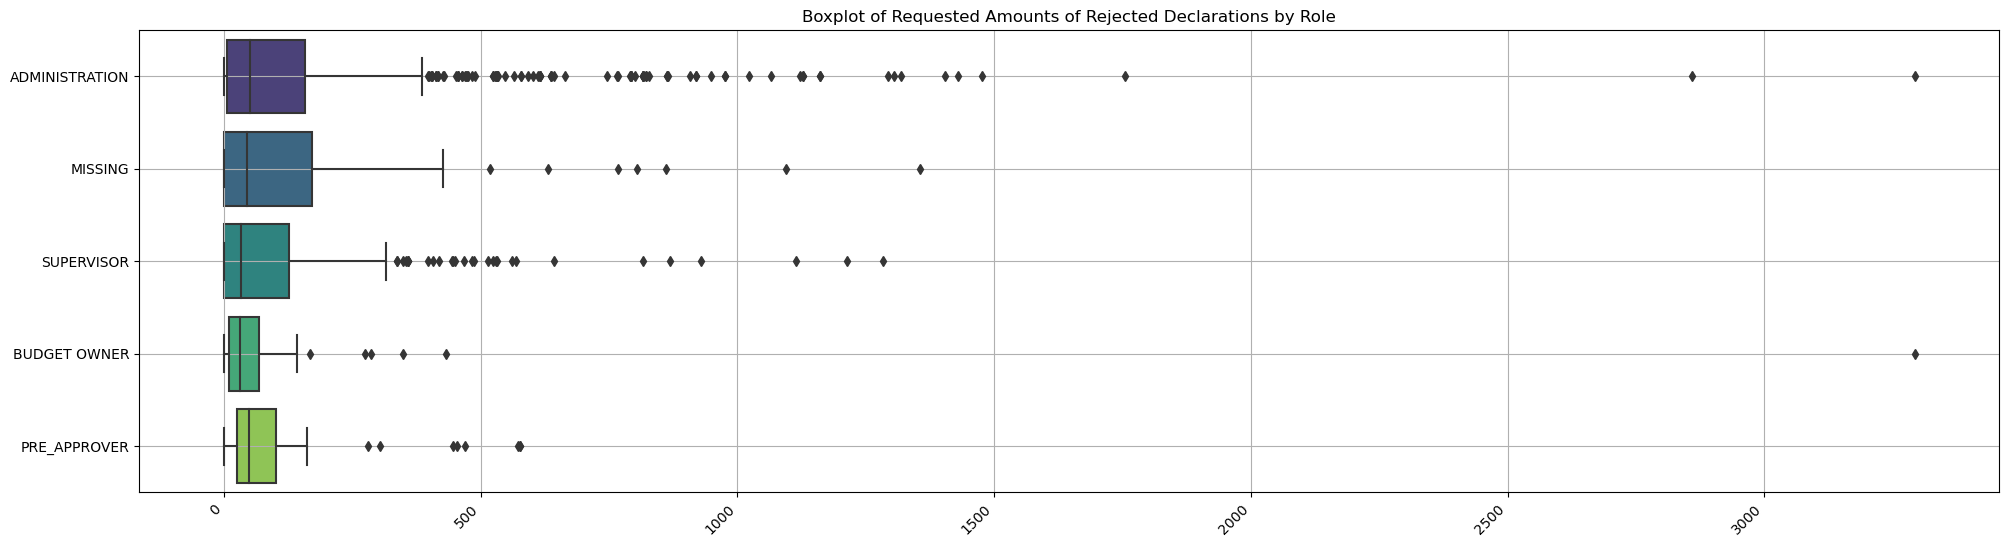

In [222]:
plt.figure(figsize=(24, 6))
sns.boxplot(x='case:Amount', y='org:role', data=log_r, palette='viridis').set(title='Boxplot of Requested Amounts of Rejected Declarations by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right')
plt.grid(True);


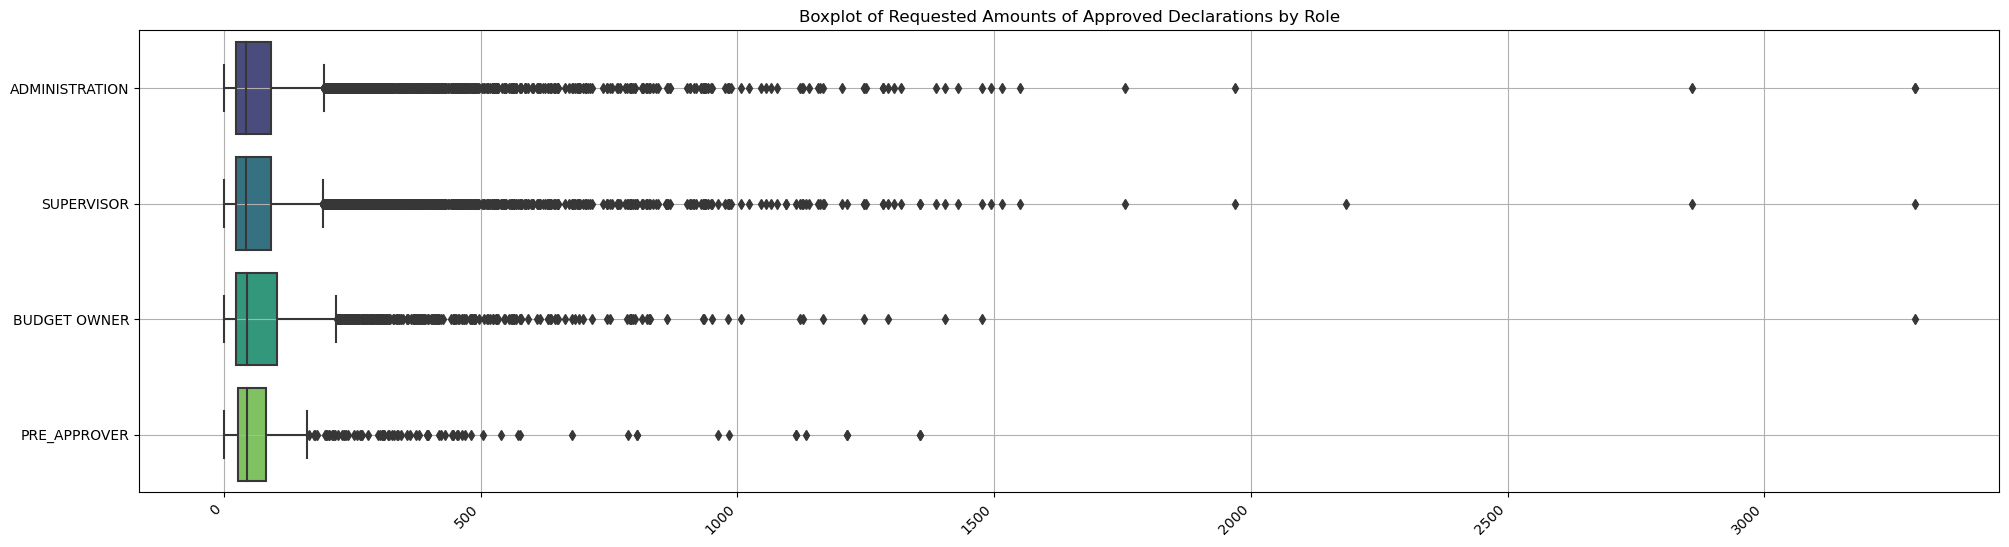

In [223]:
plt.figure(figsize=(24, 6))
sns.boxplot(x='case:Amount', y='org:role', data=log_a, palette='viridis').set(title='Boxplot of Requested Amounts of Approved Declarations by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right')
plt.grid(True);

In [224]:
log_approved = log[log['concept:name'].str.contains('Payment Handled')]  # Contains all approved declarations

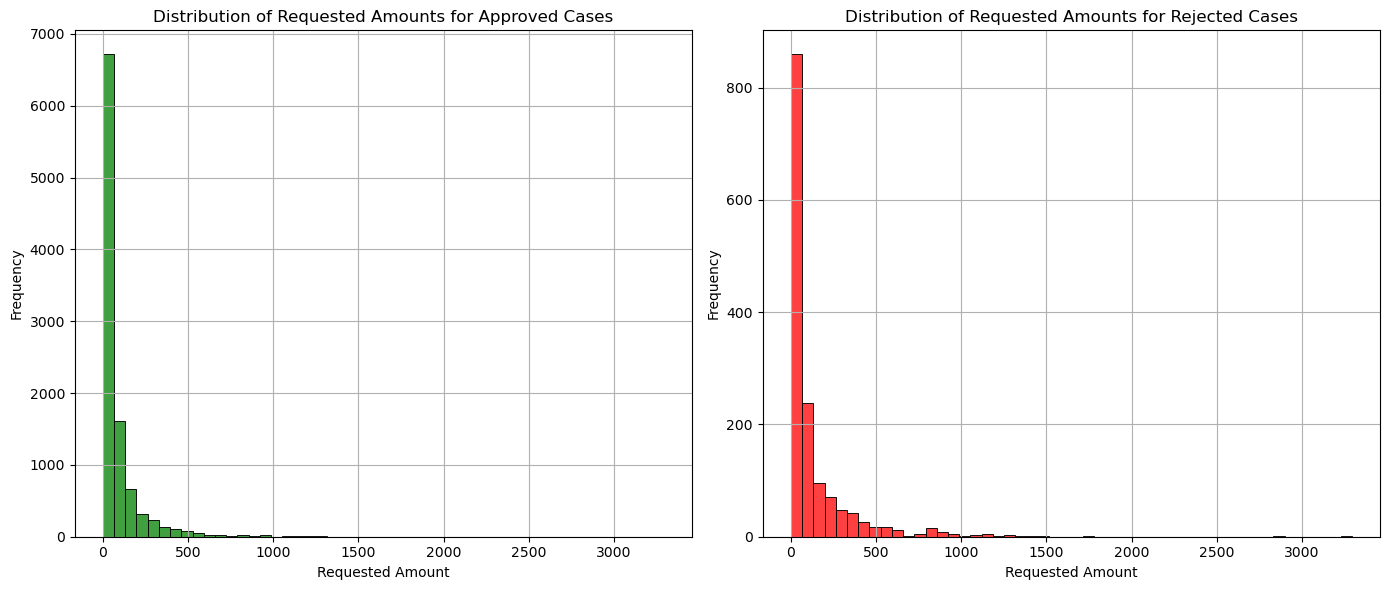

In [225]:
approved_amounts = log_approved['case:Amount']
rejected_amounts = log_r['case:Amount']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

sns.histplot(approved_amounts,color='green', kde=False, bins=50).set(title='Distribution of Requested Amounts for Approved Cases', xlabel='Requested Amount', ylabel='Frequency');
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(rejected_amounts,color='red', kde=False, bins=50).set(title='Distribution of Requested Amounts for Rejected Cases', xlabel='Requested Amount', ylabel='Frequency');
plt.grid(True)

plt.tight_layout()
plt.show()
